In [47]:
import os
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=250, threshold=250)

from src.ml.training import load_model

In [49]:
def get_predictions(data):
    parameters = {'filename': '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_nrt_all_smr_nhc'}
    model = load_model(parameters, path=basepath)
    test_predictions = model.predict(data, batch_size=128).flatten()
    return test_predictions

In [53]:
def plot_vofs(features, number_of_plots, **kwargs):
    if 'per_row' in kwargs:
        per_row = kwargs.get('per_row')
    else:
        per_row = 5
    rows = int(number_of_plots/per_row)
    print()
    if 'size' in kwargs:
        size = 150*kwargs.get('size')
    else:
        size = 150
    fig, ax = plt.subplots(rows, per_row, figsize=(3*per_row, 3*number_of_plots/per_row), dpi=size)
    if rows > 1:
        for idx_st, a_stack in enumerate(ax):
            for idx, a in enumerate(a_stack):
                a.imshow(features[idx+int(idx_st*number_of_plots/per_row)], cmap='Greys_r')
                a.get_xaxis().set_ticks([])
                a.get_yaxis().set_ticks([])
                if 'labels' in kwargs:
                    labels=kwargs.get('labels')
                    kappa = labels[idx + int(idx_st*number_of_plots/per_row)]

                    if 'hf' in kwargs:
                        hf = kwargs.get('hf')
                        hf = hf[idx + int(idx_st*number_of_plots/per_row)]
                        a.set_title(f'hf: {np.round(hf, 3)}, k: {np.round(kappa, 3)}', fontsize=14)
                    else:
                        a.set_title(f'kappa = {np.round(kappa, 3)}', fontsize=22)
    else:
        idx_st = 0
        for idx, a in enumerate(ax):
                a.imshow(features[idx+int(idx_st*number_of_plots/per_row)], cmap='Greys_r')
                a.get_xaxis().set_ticks([])
                a.get_yaxis().set_ticks([])
                if 'labels' in kwargs:
                    labels=kwargs.get('labels')
                    kappa = labels[idx + int(idx_st*number_of_plots/per_row)]

                    if 'hf' in kwargs:
                        hf = kwargs.get('hf')
                        hf = hf[idx + int(idx_st*number_of_plots/per_row)]
                        a.set_title(f'hf: {np.round(hf, 3)}, k: {np.round(kappa, 3)}', fontsize=12)
                    else:
                        a.set_title(f'kappa = {np.round(kappa, 3)}', fontsize=22)
                    
    fig.tight_layout()

In [9]:
def create_plot(labels, predictions, color, parameters, **kwargs):
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Create scatterplot test_predictions vs test_labels
    alpha = 0.1
    marker = kwargs.get('marker') if 'marker' in kwargs else ','
    size = (kwargs.get('size') if 'size' in kwargs else 1)
    plt.scatter(labels, predictions, alpha=alpha, color=color, edgecolors='none', marker=marker, s=size)  # darkseagreen
    
    if 'axis' in kwargs:
        axis = kwargs.get('axis')
        if axis == 'equal':
            lims = [[min(predictions), max(predictions)], [min(predictions), max(predictions)]]
            # Plot the 45 degree line
            ax.plot(lims[0], lims[0], color='gray')
        else:
            lims = [[min(labels), max(labels)], [min(predictions), max(predictions)]]
        
    else:
        lims = [[min(predictions), max(predictions)], [min(predictions), max(predictions)]]
        # Plot the 45 degree line
        ax.plot(lims[0], lims[0], color='gray')
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
 
    fig.tight_layout()

    return fig, ax


In [10]:
import time

from sklearn.base import (
    BaseEstimator,  # for get_params, set_params
    TransformerMixin     # for fit_transform
)

class TransformData(BaseEstimator, TransformerMixin):
    def __init__(self, parameters, reshape=False):
        self.parameters = parameters
        self.reshape = reshape

    def fit(self, dataset):
        return self  # Nothing to do

    def transform(self, dataset):
        # Split the training and test data into labels (first column) and data
        # dataset = dataset[dataset.iloc[:, 0] > 0]  # Pos values only
        labels = dataset.iloc[:, 0].to_numpy()
        data = dataset.iloc[:, 1:].to_numpy()

        labels = np.round(labels, 5)
        data = np.round(data, 5)

        if self.reshape:
            st_sz = self.parameters['stencil_size']
            # Reshape data
            data = np.reshape(data, (data.shape[0], st_sz[0], st_sz[1], 1))

        return [labels, data]

    
class FindGradient(BaseEstimator, TransformerMixin):
    def __init__(self, parameters):
        self.parameters = parameters

    def fit(self, dataset):
        return self

    def get_gradient(self, data):
        time0 = time.time()
        # Get points where gradient should not be calculated
        no_interface = np.nonzero((data == 1) | (data == 0))
        # Initialize gradient matrices
        grad_x = np.empty((data.shape))  # * np.nan
        grad_y = np.empty((data.shape))  # * np.nan
        grad_x.fill(np.nan)
        grad_y.fill(np.nan)
        # If stencil is 5x5 or bigger, use central difference quotient
        if (data.shape[1] >= 5) & (data.shape[2] >= 5):
            # Calculate gradient
            for x in range(1, data.shape[1]-1):
                for y in range(1, data.shape[2]-1):
                    grad_x[:, y, x, 0] = np.array([
                        data[:, y, x+1, 0] -
                        data[:, y, x-1, 0]
                    ])/2
                    grad_y[:, y, x, 0] = np.array([
                        data[:, y-1, x, 0] -
                        data[:, y+1, x, 0]
                    ])/2
        # If stencil has other dimensions (e.g. 3x3), use fallback (forward/central/backward d.q.)
        else:
            mp = [int((data.shape[1]-1)/2), int((data.shape[2]-1)/2)]  # y, x
            # Calculate gradient x
            for y in range(mp[0]-1, mp[0]+2):
                # Backward difference quotient
                grad_x[:, y, mp[1]-1, 0] = np.array([
                    data[:, y, mp[1], 0] -
                    data[:, y, mp[1]-1, 0]
                ])/1  # mathematically correct: /1, but /2 works much better in this application
                # Central difference quotient
                grad_x[:, y, mp[1], 0] = np.array([
                    data[:, y, mp[1]+1, 0] -
                    data[:, y, mp[1]-1, 0]
                ])/2
                # Forward difference quotient
                grad_x[:, y, mp[1]+1, 0] = np.array([
                    data[:, y, mp[1]+1, 0] -
                    data[:, y, mp[1], 0]
                ])/1
            for x in range(mp[1]-1, mp[1]+2):
                # Backward difference quotient
                grad_y[:, mp[0]-1, x, 0] = np.array([
                    data[:, mp[0]-1, x, 0] -
                    data[:, mp[0], x, 0]
                ])/1
                # Central difference quotient
                grad_y[:, mp[0], x, 0] = np.array([
                    data[:, mp[0]-1, x, 0] -
                    data[:, mp[0]+1, x, 0]
                ])/2
                # Forward difference quotient
                grad_y[:, mp[0]+1, x, 0] = np.array([
                    data[:, mp[0], x, 0] -
                    data[:, mp[0]+1, x, 0]
                ])/1
        grad_x[no_interface] = np.nan
        grad_y[no_interface] = np.nan
        # angle = np.arctan2(-grad_y, -grad_x)*180/np.pi  # y, x
        # angle = gradient[1]
        return [grad_y, grad_x]

    def get_mid_gradient(self, data):
        time0 = time.time()
        # Get stencil size
        st_sz = self.parameters['stencil_size']
        # Calculate midpoint
        mp = [int((st_sz[0]-1)/2), int((st_sz[1]-1)/2)]
        # Calculate gradient in midpoint
        grad_x = np.array([
            data[:, mp[0], mp[1]+1, 0] -
            data[:, mp[0], mp[1]-1, 0]
        ])/2
        grad_y = np.array([
            data[:, mp[0]-1, mp[1], 0] -
            data[:, mp[0]+1, mp[1], 0]
        ])/2

        return [grad_y, grad_x]

    def transform(self, dataset):
        time0 = time.time()
        # Get stencil size
        st_sz = self.parameters['stencil_size']
        # Seperate data from labels
        data = dataset[1].copy()
        # Get shape of data
        shape = data.shape
        # Check if data was transformed (shape = 4) or not (shape = 2), reshape data that was not transformed
        if len(shape) == 2:
            data = np.reshape(data, (shape[0], st_sz[0], st_sz[1], 1))
        if self.parameters['angle']:
            # Get gradient matrix
            [grad_y, grad_x] = self.get_gradient(data)
        else:
            # Get gradient in midpoint only (much faster) if angle matrix is not needed
            [grad_y, grad_x] = self.get_mid_gradient(data)

        # Reshape to tensor if angle matrix is needed, otherwise just output vectors
        if (data.shape != shape) & (self.parameters['angle']):
            # Reshape transformed data to original shape
            grad_y = np.reshape(grad_y, shape)
            grad_x = np.reshape(grad_x, shape)

        return [dataset[0], dataset[1], grad_x, grad_y]

    
class HF(BaseEstimator, TransformerMixin):
    def __init__(self, parameters):
        self.parameters = parameters

    def fit(self, dataset):
        return self

    def transform(self, dataset):
        # time0 = time.time()
        # Get stencil size
        st_sz = self.parameters['stencil_size']
        # Seperate data from labels
        data = dataset[1].copy()
        grad_x = dataset[2][0]
        grad_y = dataset[3][0]
        # Get shape of data
        shape = data.shape
        # Check if data was transformed (shape = 4) or not (shape = 2), reshape data that was not transformed
        if len(shape) == 2:
            data = np.reshape(data, (shape[0], st_sz[0], st_sz[1], 1))

        # Get midpoint
        i = int((st_sz[0]-1)/2)
        j = int((st_sz[1]-1)/2)

        # Find stencils where gradient points more in y direction (g_y) or x direction (g_x)
        g_y = np.nonzero((np.abs(grad_y) > np.abs(grad_x)) == True)
        g_x = np.nonzero((np.abs(grad_y) > np.abs(grad_x)) == False)

        # Initialize height function vectors
        h1 = np.zeros((data.shape[0]))
        h2 = np.zeros((data.shape[0]))
        h3 = np.zeros((data.shape[0]))
        # Hier läuft noch irgendwas schief
        # Calculate height function values for stencils in y-direction
        for a in np.arange(0, 2*i+1):
            h1[g_y] = np.sum([h1[g_y], data[g_y, a, j-1, 0]], axis=0)
            h2[g_y] = np.sum([h2[g_y], data[g_y, a, j, 0]], axis=0)
            h3[g_y] = np.sum([h3[g_y], data[g_y, a, j+1, 0]], axis=0)
        # Calculate height function values for stencils in x-direction
        for b in np.arange(0, 2*j+1):
            h1[g_x] = np.sum([h1[g_x], data[g_x, i-1, b, 0]], axis=0)
            h2[g_x] = np.sum([h2[g_x], data[g_x, i, b, 0]], axis=0)
            h3[g_x] = np.sum([h3[g_x], data[g_x, i+1, b, 0]], axis=0)

        # Delta = 1/1000  # see data generation
        Delta = 1

        # Calculate derivatives
        h_x = (h1-h3)/(2*Delta)
        h_xx = (h3-2*h2+h1)/(Delta**2)
        # h_x = (h1-h3)/(2)
        # h_xx = (h3-2*h2+h1)

        # Calculate kappa
        kappa = np.round(
            2/Delta*h_xx/((1+np.multiply(h_x, h_x))**(3/2))
            , 5)

        # Reshape to tensor if angle matrix is needed, otherwise just output vectors
        if (data.shape != shape) & (self.parameters['angle']):
            # Reshape transformed data to original shape
            data = np.reshape(data, shape)

        return [dataset[0], dataset[1], np.array([kappa]).T]


Shape:	(1000000, 50)
[1000000, 1000, 7]
max:	0.444,	min:	-0.444



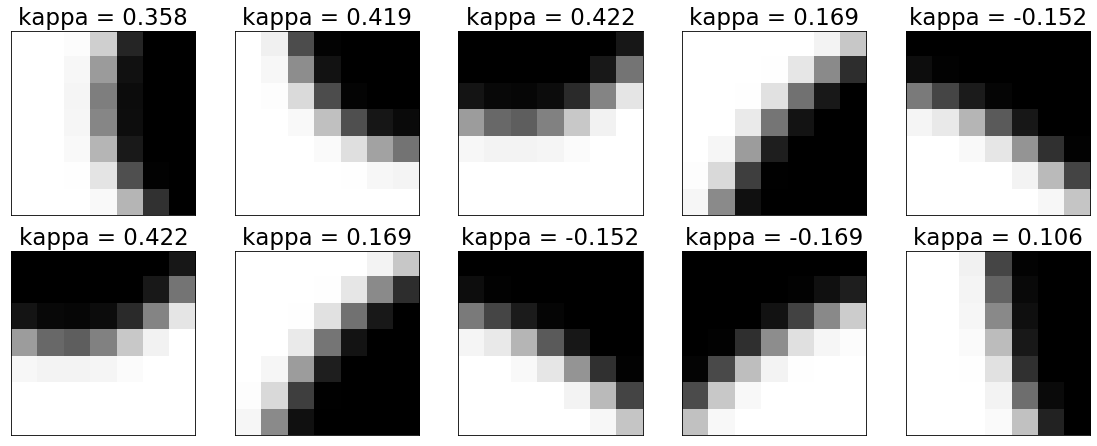

In [54]:
#filename = 'data_5x5_eqk_neg_ellre.feather'
#filename = 'data_5x5_eqk_neg_cir_smr_woxc.feather'
filename = 'data_7x7_eqk_neg_ell_smr.feather'
file = pd.read_feather(filename)
print(f'Shape:\t{file.shape}')
#file = file[(file.iloc[:, 0] > 0.424) & (file.iloc[:, 0] < 0.425)]

debug = False
if not debug:
    features = file.iloc[:, 1:]
    labels = file.iloc[:, 0]
    dataset = file
else:
    pt_x = file.iloc[:, 0]
    pt_y = file.iloc[:, 1]
    e = file.iloc[:, 2]
    r = file.iloc[:, 3]
    labels = file.iloc[:, 4]
    features = file.iloc[:, 5:]
print([int(features.shape[0]), int(np.sqrt(features.shape[0])), int(np.sqrt(features.shape[1]))])
print(f'max:\t{np.round(max(labels),3)},\tmin:\t{np.round(min(labels),3)}')

st_sz = [int(np.sqrt(features.shape[1])), int(np.sqrt(features.shape[1]))]

parameters = {'stencil_size': st_sz, 'angle': False}

features_plt = np.reshape(features.values, (int(features.shape[0]), int(np.sqrt(features.shape[1])), int(np.sqrt(features.shape[1]))))

# plot_vofs(features, labels.values, 24, per_row = 7)
plot_vofs(features_plt, 10, labels=labels.values, per_row = 5, size=0.5)

In [55]:


predictions = get_predictions(features)
idx = 6
print(np.reshape(features.iloc[idx,:].values, (7, 7)))
print(predictions[idx])
print(labels[idx])

param_str:
_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_nrt_all_smr_nhc
[[1.         1.         0.88903809 0.2166748  0.0144043  0.         0.        ]
 [1.         1.         0.90649414 0.3190918  0.03149414 0.         0.        ]
 [1.         1.         0.92871094 0.45336914 0.05371094 0.         0.        ]
 [1.         1.         0.95703125 0.62207031 0.0838623  0.         0.        ]
 [1.         1.         0.99023438 0.7947998  0.15808105 0.00183105 0.        ]
 [1.         1.         1.         0.90075684 0.35803223 0.03552246 0.        ]
 [1.         1.         1.         0.96411133 0.6418457  0.12023926 0.        ]]
0.09666398
0.106125646289855


(39101, 49)



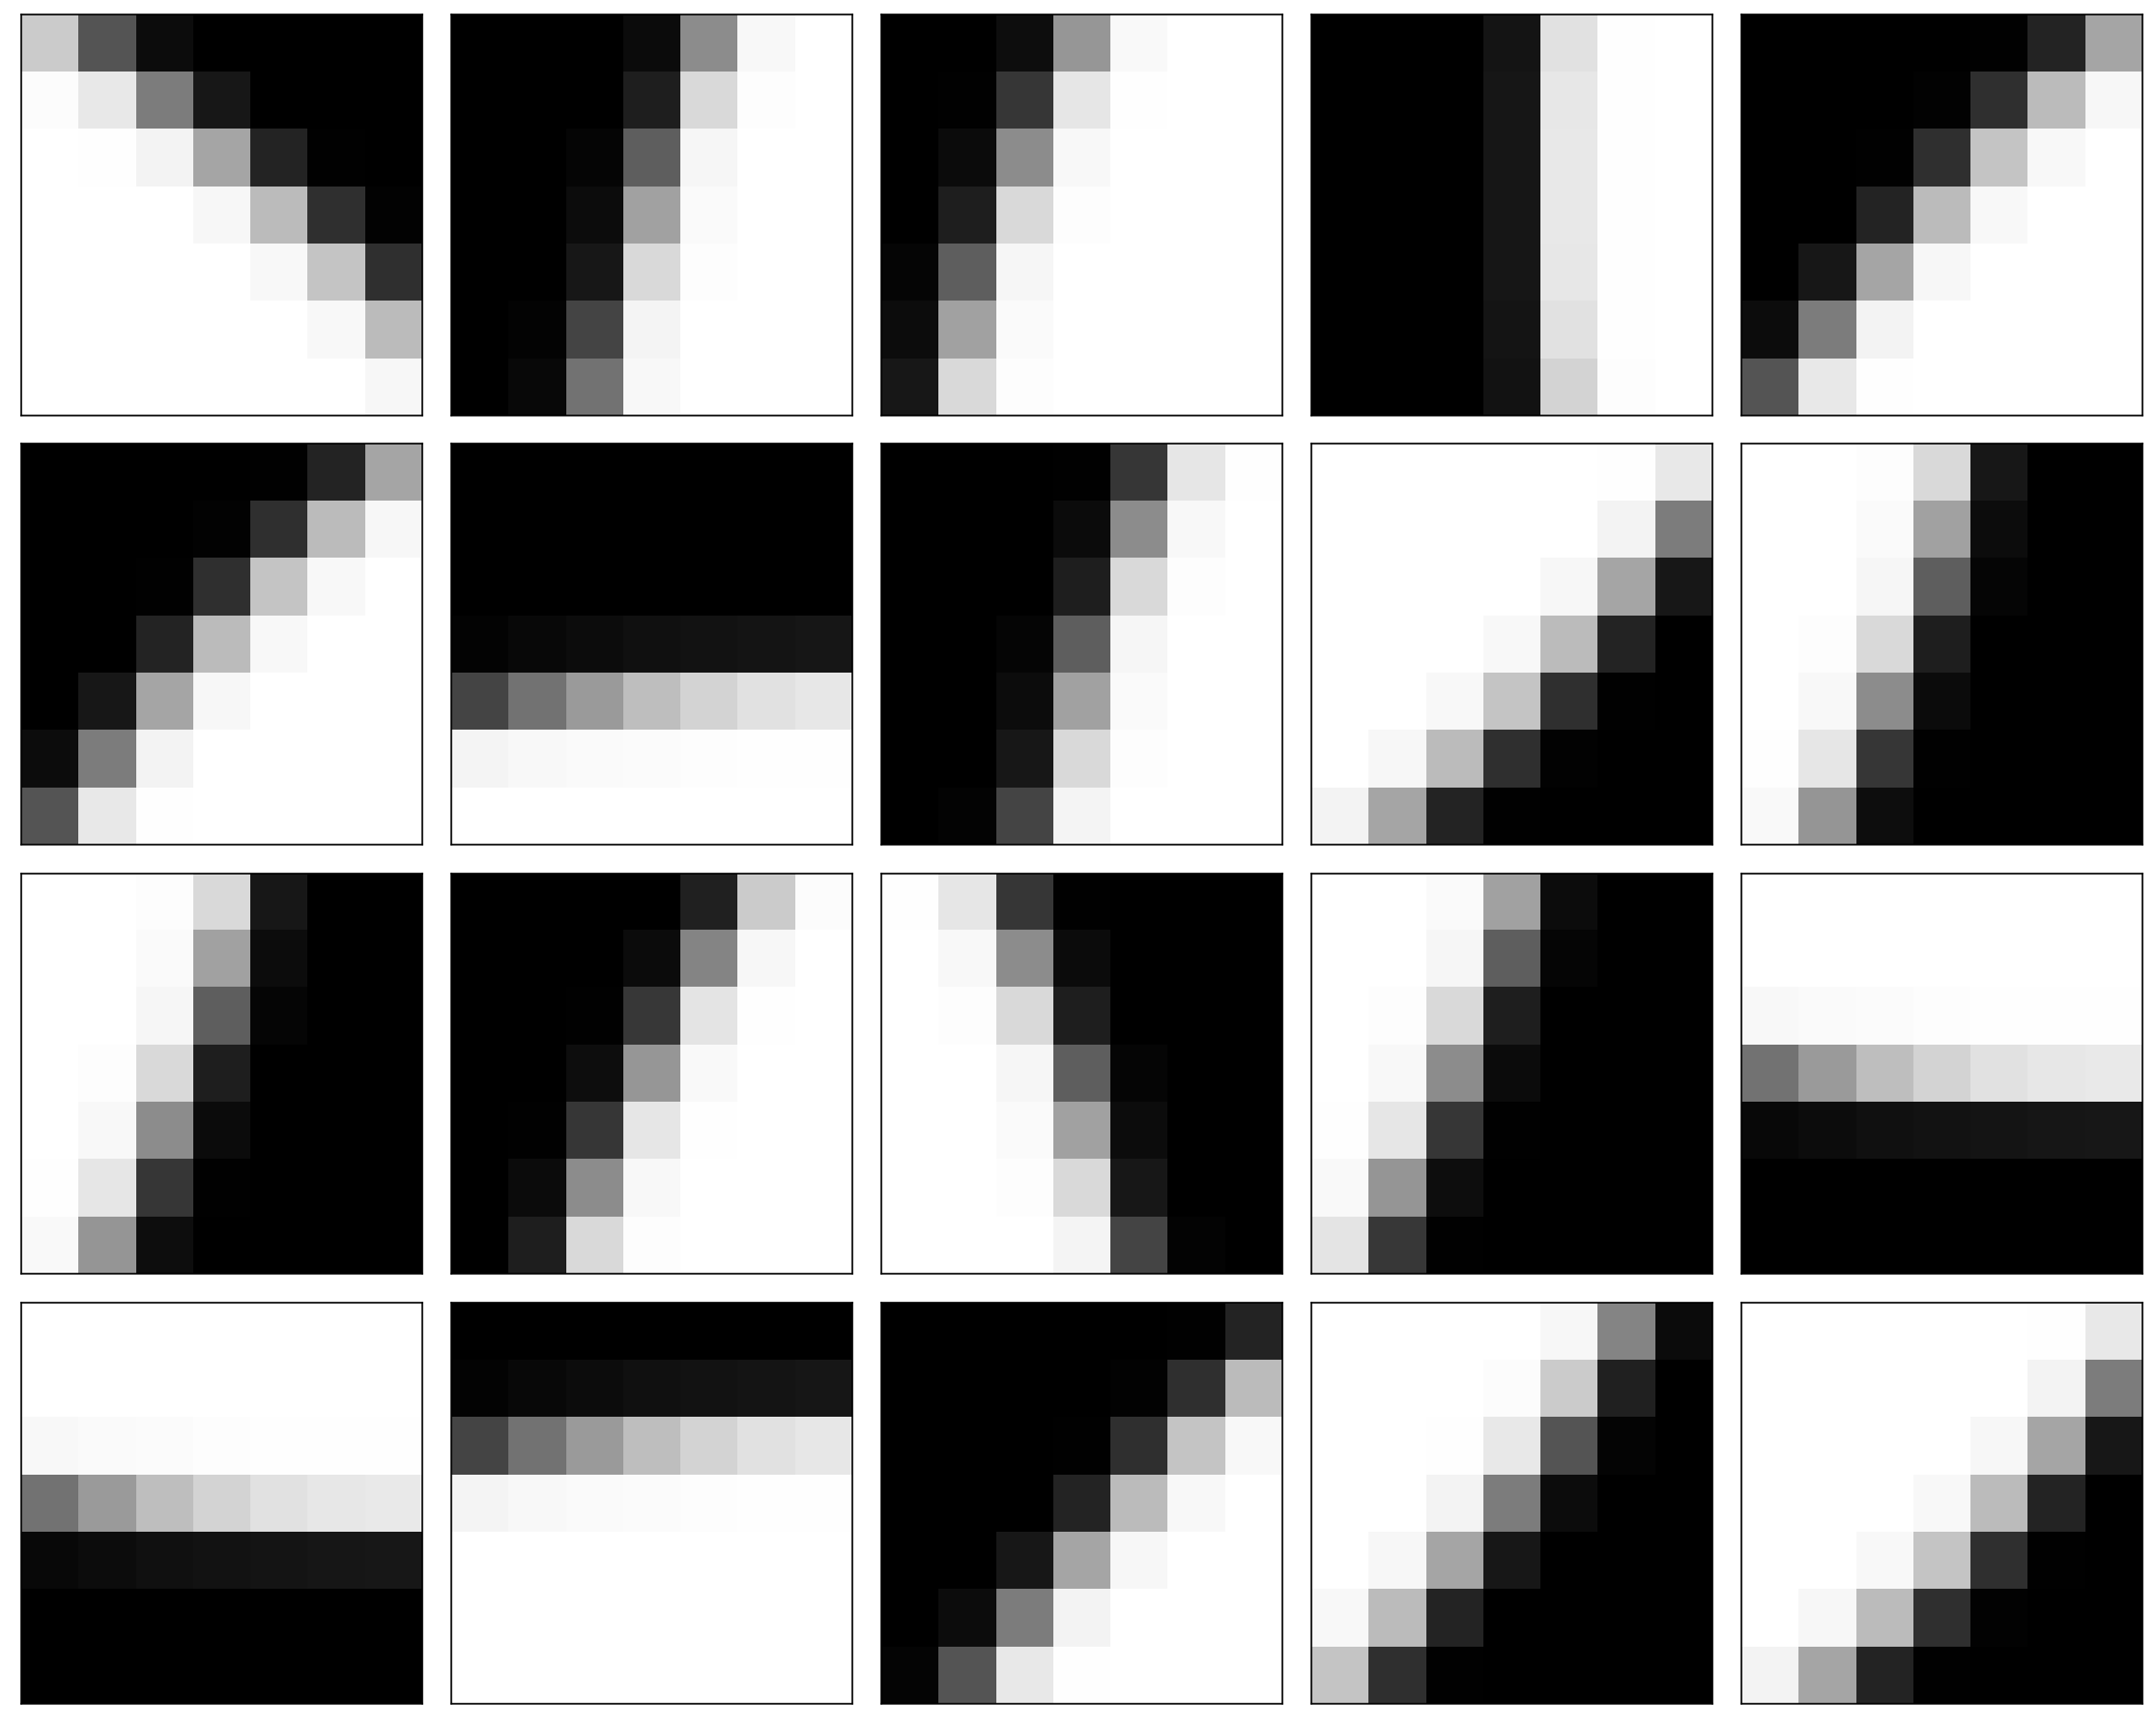

In [126]:
vector = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', 'output_c.txt'), skiprows=1).values

#'''
# Get random values
np.random.seed(42)
indices = np.random.permutation(vector.shape[0])
vector = vector[indices]
#'''
print(vector.shape)
array = np.reshape(vector, (vector.shape[0],7,7))
plot_vofs(array, 20, per_row=5)

(39101, 49)



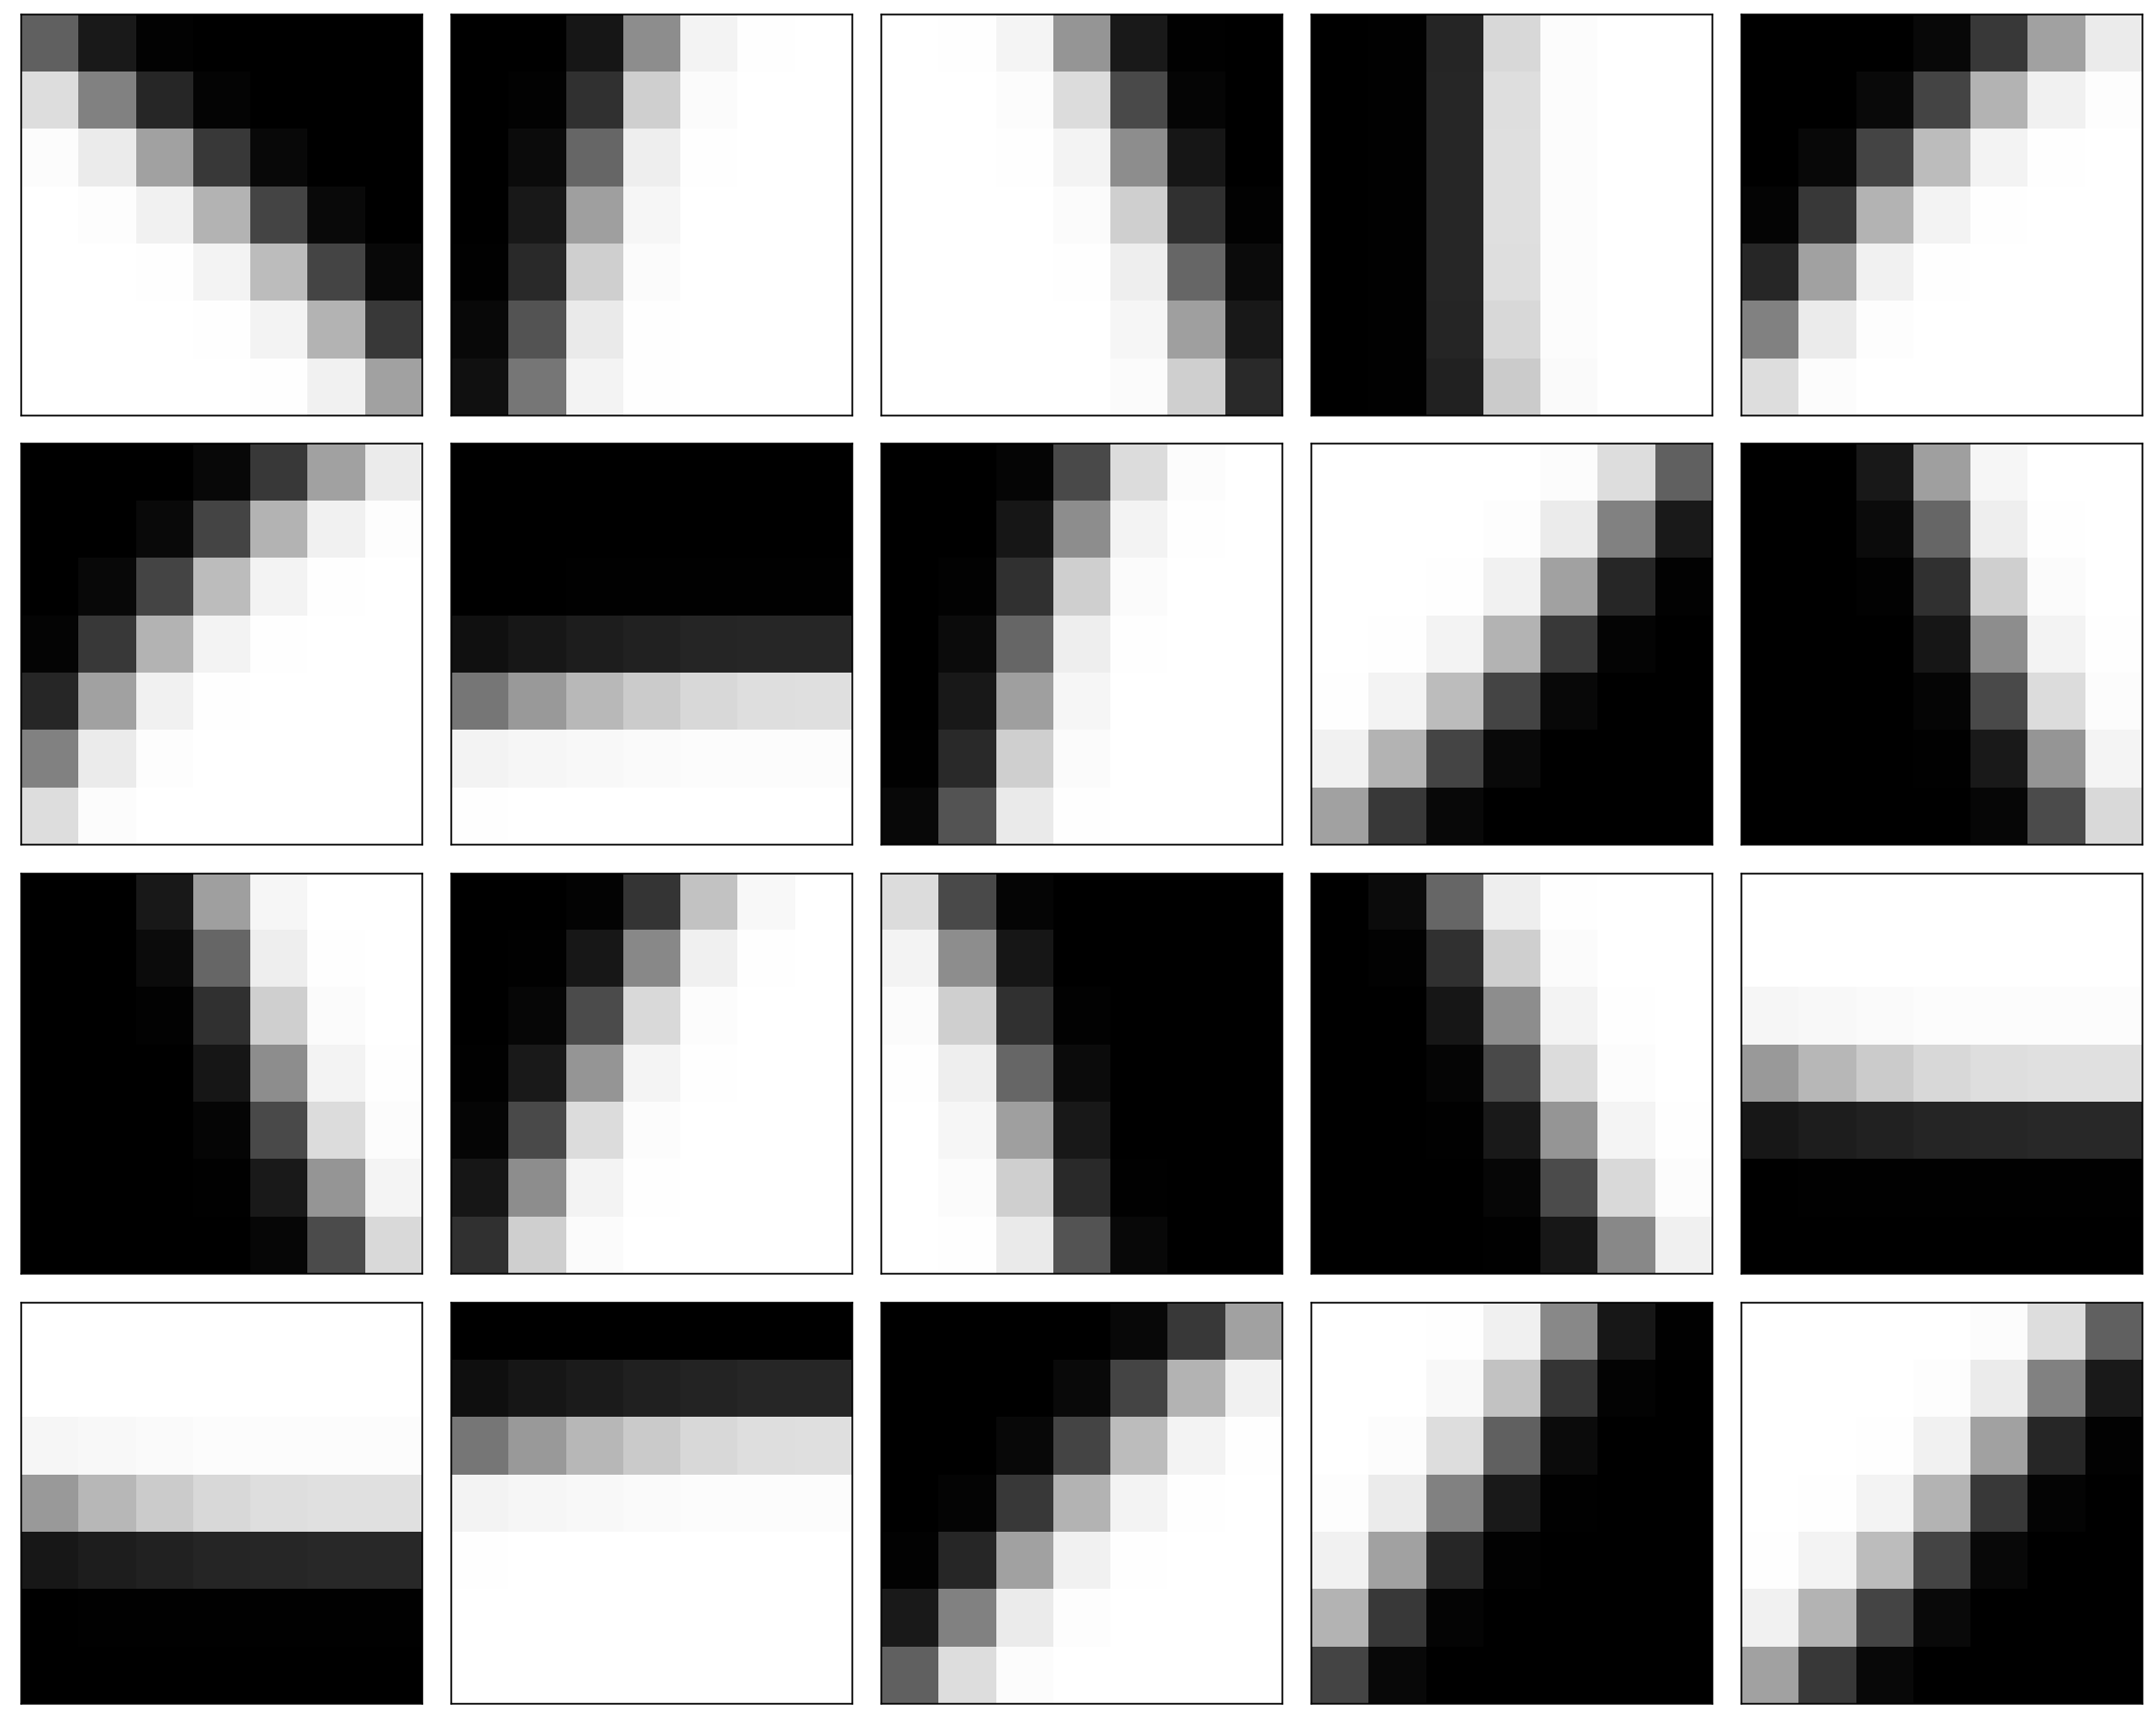

In [127]:
vector = pd.read_csv(os.path.join('/'+basepath, 'data', 'fortran_test', 'output_cm.txt'), skiprows=1).values
#'''
# Get random values
#np.random.seed(42)
#indices = np.random.permutation(vector.shape[0])
vector = vector[indices]
#'''
print(vector.shape)
array = np.reshape(vector, (vector.shape[0],7,7))
plot_vofs(array, 20, per_row=5)

In [103]:
fortran_predictions = get_predictions(vector)
idx = list(range(1,10))
print(np.reshape(vector[idx,:], (vector[idx,:].shape[0], 7, 7)))
print(fortran_predictions[idx])
print(-0.5)

param_str:
_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_nrt_all_smr_nhc
[[[0.         0.00347222 0.07465278 ... 0.90444444 0.995      1.        ]
  [0.00013889 0.01138889 0.159375   ... 0.96506944 0.99875    1.        ]
  [0.00173611 0.04263889 0.33034723 ... 0.99229167 1.         1.        ]
  ...
  [0.00770833 0.13743055 0.71020833 ... 0.99868056 1.         1.        ]
  [0.02840278 0.25541667 0.84673611 ... 0.99993056 1.         1.        ]
  [0.05513889 0.39000001 0.89993056 ... 1.         1.         1.        ]]

 [[1.         0.99513889 0.90847222 ... 0.08958333 0.00472222 0.        ]
  [1.         0.999375   0.97604167 ... 0.22819444 0.02284722 0.000625  ]
  [1.         1.         0.995      ... 0.47013889 0.07465278 0.00347222]
  ...
  [1.         1.         1.         ... 0.86611111 0.33034723 0.04263889]
  [1.         1.         1.         ... 0.92875    0.53034722 0.08381944]
  [1.         1.         1.         ... 0.96555555 0.71020833 0.13743055]]

 [[0.         0.0059

Shape:	(996781, 26)
[612, 24, 5]
max:	0.425,	min:	0.424



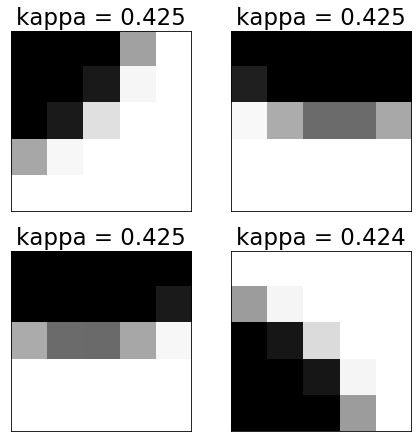

In [36]:
#filename = 'data_5x5_eqk_neg_ellre.feather'
filename = 'data_5x5_eqk_neg_cir_nsm_woxc.feather'
file = pd.read_feather(filename)
print(f'Shape:\t{file.shape}')
file = file[(file.iloc[:, 0] > 0.424) & (file.iloc[:, 0] < 0.425)]

debug = False
if not debug:
    features = file.iloc[:, 1:]
    labels = file.iloc[:, 0]
    dataset = file
else:
    pt_x = file.iloc[:, 0]
    pt_y = file.iloc[:, 1]
    e = file.iloc[:, 2]
    r = file.iloc[:, 3]
    labels = file.iloc[:, 4]
    features = file.iloc[:, 5:]
print([int(features.shape[0]), int(np.sqrt(features.shape[0])), int(np.sqrt(features.shape[1]))])
print(f'max:\t{np.round(max(labels),3)},\tmin:\t{np.round(min(labels),3)}')

st_sz = [int(np.sqrt(features.shape[1])), int(np.sqrt(features.shape[1]))]

parameters = {'stencil_size': st_sz, 'angle': False}

features = np.reshape(features.values, (int(features.shape[0]), int(np.sqrt(features.shape[1])), int(np.sqrt(features.shape[1]))))

# plot_vofs(features, labels.values, 24, per_row = 7)
plot_vofs(features, 4, labels=labels.values, per_row = 2, size=0.5)

In [6]:
from sklearn.pipeline import Pipeline

reshape = False

# dataset = dataset[(dataset.iloc[:, 0] > 0.42) & (dataset.iloc[:, 0] < 0.43)]

print(dataset.shape)

data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=reshape)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findkappahf', HF(parameters=parameters)),
])
# Execute pipeline
[pip_labels, pip_features, kappa] = data_pipeline.fit_transform(dataset)
pip_labels = pip_labels
pip_features = np.reshape(pip_features, (int(pip_features.shape[0]), int(np.sqrt(pip_features.shape[1])), int(np.sqrt(pip_features.shape[1]))))
kappa = kappa

(1000000, 26)


In [7]:
###### LIMITS ######
upper_limit = 0.43
lower_limit = 0.42

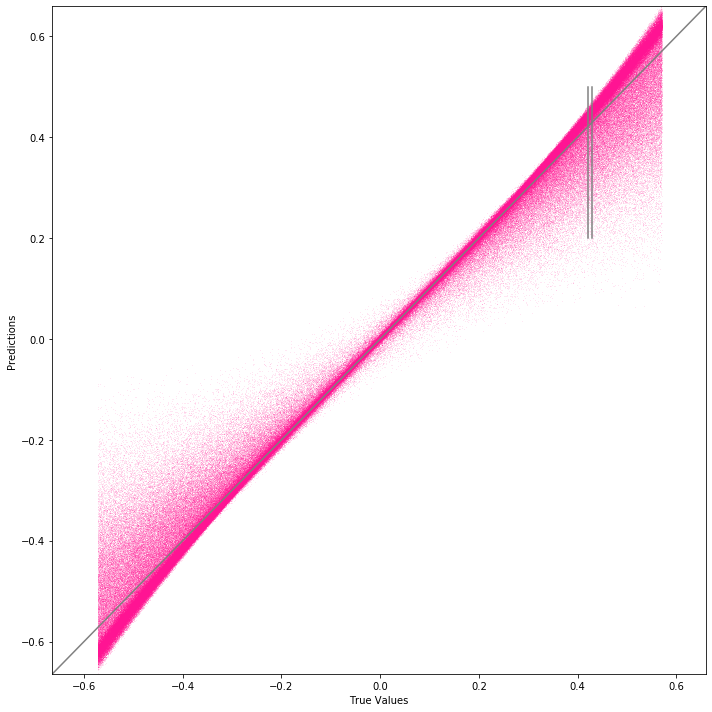

In [8]:
fig, ax = create_plot(labels, kappa, color='deeppink', parameters=parameters)
ax.plot([upper_limit, upper_limit], [0.2, 0.5], color='gray')
ax.plot([lower_limit, lower_limit], [0.2, 0.5], color='gray')
plt.show()

In [9]:
indices = np.nonzero((pip_labels > lower_limit) & (pip_labels < upper_limit))
pip_labels = np.reshape(pip_labels, (pip_labels.shape[0], 1))
kappa = kappa[indices]
pip_features = pip_features[indices[0], :, :]
pip_labels = pip_labels[indices]

pip_labels = np.reshape(pip_labels, (pip_labels.shape[0], 1))
kappa = np.reshape(kappa, (kappa.shape[0], 1))
#pip_features = np.reshape(pip_features, (pip_features.shape[0], pip_features.shape[1]**2))

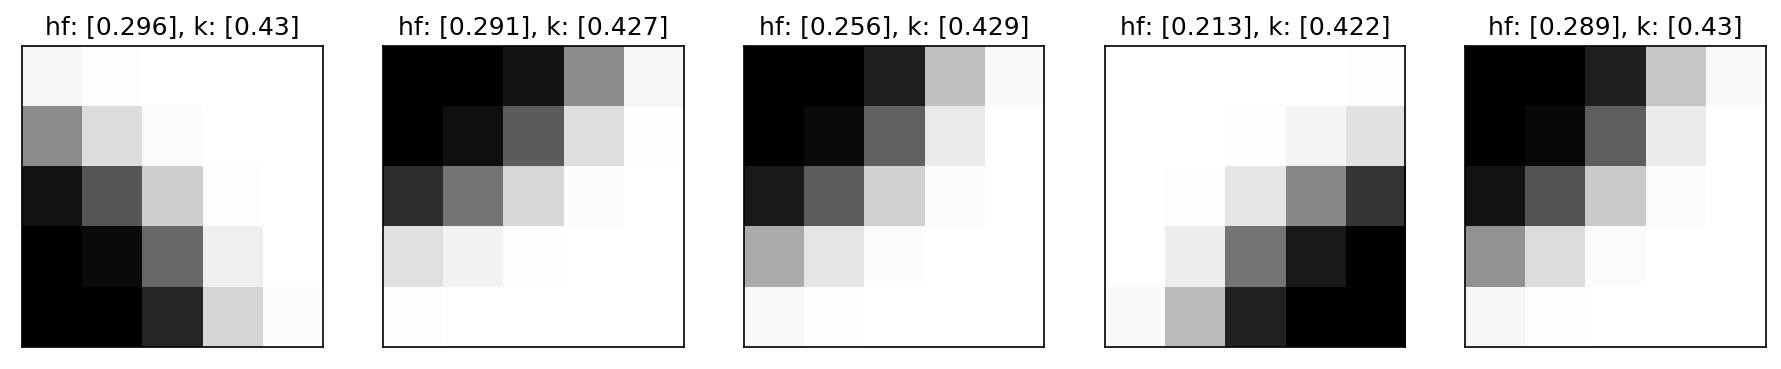

In [10]:
indices = np.nonzero(kappa < 0.3)[0]
f = pip_features[indices, :, :]
l = pip_labels[indices, :]
k = kappa[indices, :]
plot_vofs(f, l, 5, hf=k)

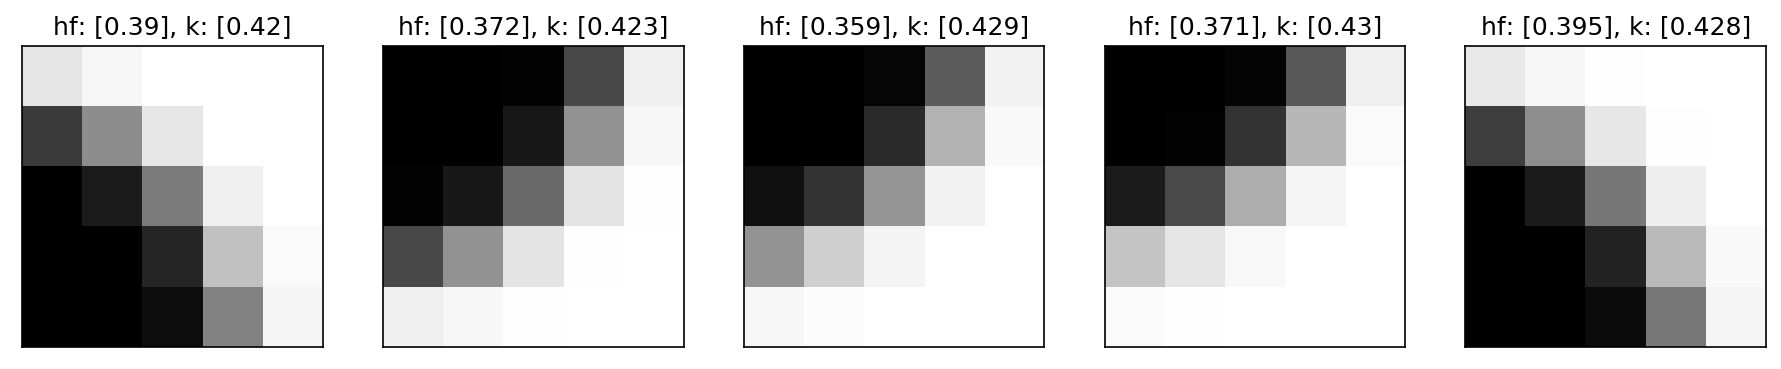

In [11]:
indices = np.nonzero((kappa < 0.4) & (kappa > 0.3))[0]
f = pip_features[indices, :, :]
l = pip_labels[indices, :]
k = kappa[indices, :]
plot_vofs(f, l, 5, hf=k)

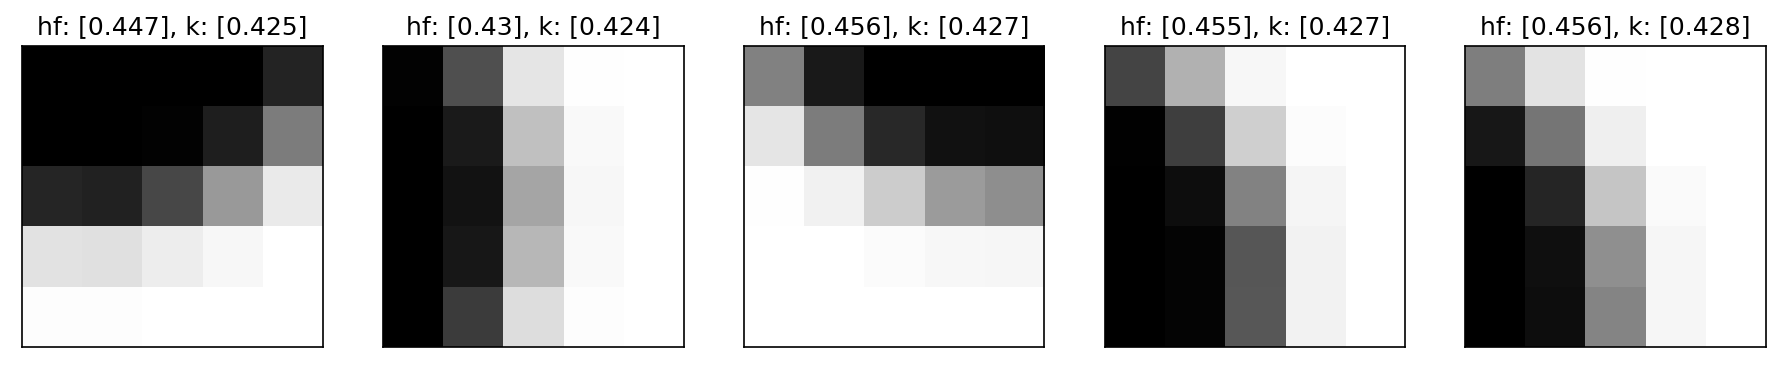

In [12]:
indices = np.nonzero((kappa < 0.6) & (kappa > 0.4))[0]
f = pip_features[indices, :, :]
l = pip_labels[indices, :]
k = kappa[indices, :]
plot_vofs(f, l, 5, hf=k)

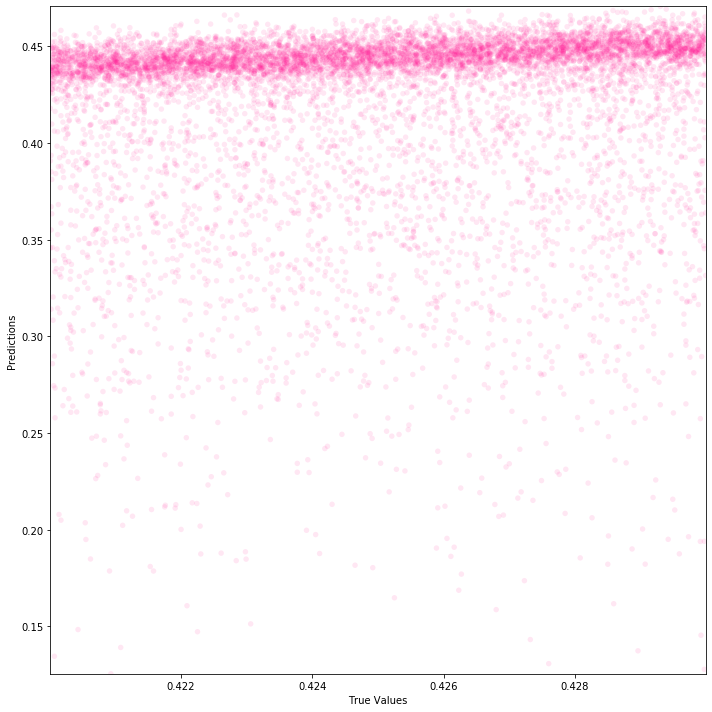

'\nHier die Daten an den Graphen bringen, also Beispiele von oben mit 5x5 stencils\n'

In [13]:
l = np.reshape(pip_labels, (pip_labels.shape[0],))
create_plot(l, kappa, color='deeppink', parameters=parameters, marker='o', size = 30, axis = 'notequal')
plt.show()


'''
Hier die Daten an den Graphen bringen, also Beispiele von oben mit 5x5 stencils
'''

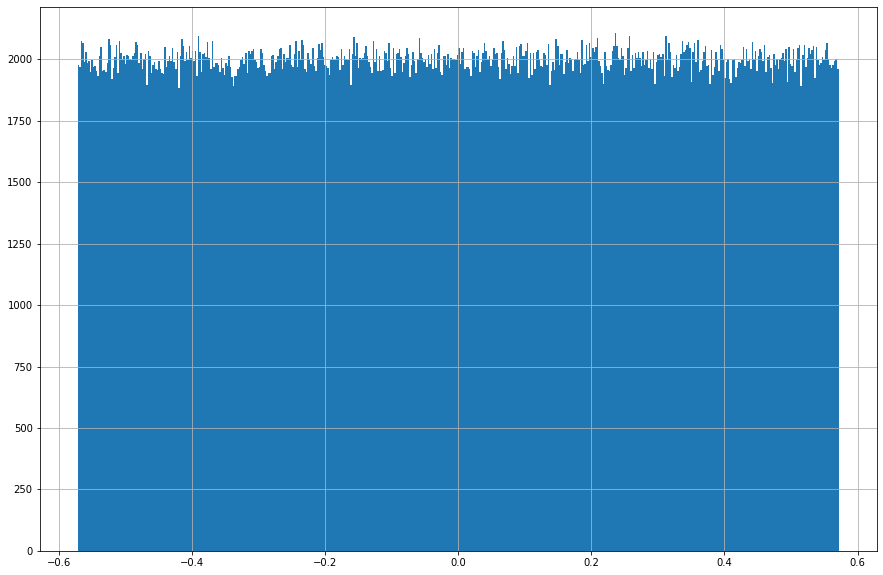

In [14]:
labels.hist(bins=int(2/0.004), figsize=(15,10))

In [15]:
file.iloc[:, int(file.shape[1]/2)].nunique()

6442

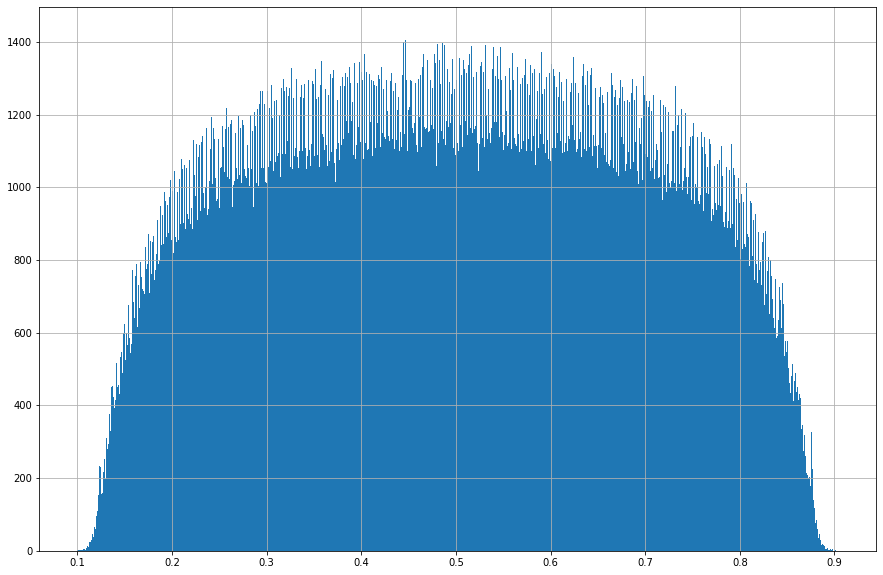

In [16]:
file.iloc[:, int(file.shape[1]/2)].hist(bins=1023, figsize=(15,10))

Die Spikes sind etwas seltsam, hängen auch von der Wahl der Auflösung des Histogramms ab.

In [17]:
sum = file.sum(axis=1)
sum.nunique()

1000000

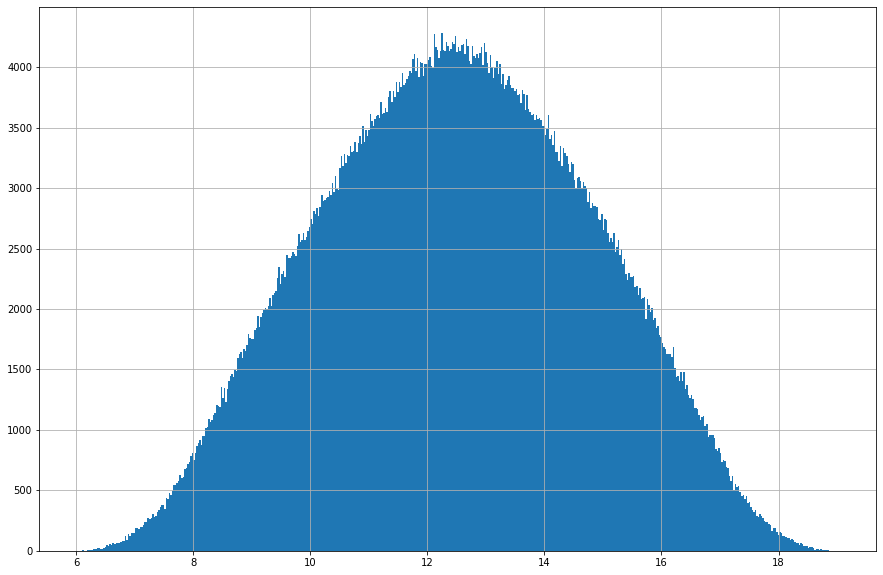

In [18]:
sum.hist(bins=500, figsize=(15, 10))